**get model coordinates**

In [2]:
import plotly.express as px
import pandas as pd
import numpy as np

coor = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Marin/meteorological_models/distan_lat42.3394lon-8.8339p10R1Km.csv")
px.set_mapbox_access_token("pk.eyJ1IjoiZ3JhbmFudHVpbiIsImEiOiJja3B4dGU4OTkwMTFmMm9ycnNhMjJvaGJqIn0.VWzx_PkD9A5cSUVsn_ijCA")
px.scatter_mapbox(coor, hover_data=['distance'],lat='lat', lon='lon',color='distance', title="nearest points",
                           color_continuous_scale=px.colors.cyclical.IceFire,)

**get station and sample mean direction hour before**

In [3]:
from pandas.core.arrays import categorical
station = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Marin/meteorological_stations/ria_enm_windplus.csv", usecols = ["time","dir_udr"],parse_dates=["time"]).set_index("time")
print("raw data\n",station.head(24))

#show duplicated
df_duplicate = station[station.index.duplicated()]
print("duplicated")
print(df_duplicate)

#delete duplicated and resample
station = station[~station.index.duplicated(keep='first')]
station = station.resample("H",label="right",closed="right").mean()

#label
#dir udr to interval
interval=pd.IntervalIndex.from_tuples([(-0.5,20), (20, 40), (40, 60),
                                       (60,80),(80,100),(100,120),(120,140),(140,160),
                                       (160,180),(180,200),(200,220),(220,240),
                                       (240,260),(260,280),(280,300),(300,320),
                                       (320,340),(340,360)])
labels=['[0, 20]', '(20, 40]', '(40, 60]','(60, 80]', '(80, 100]', '(100, 120]',
        '(120, 140]','(140, 160]', '(160, 180]', '(180, 200]', '(200, 220]',
        '(220, 240]', '(240, 260]', '(260, 280]', '(280, 300]','(300, 320]',
        '(320, 340]', '(340, 360]']
station["dir_o_l"] = pd.cut(station["dir_udr"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
station = station.drop(["dir_udr"],axis=1)
print("Climatology ")
round(station["dir_o_l"].value_counts(normalize=True),2)


raw data
                      dir_udr
time                        
2021-03-11 00:10:00    198.0
2021-03-11 00:20:00    196.0
2021-03-11 00:30:00    197.0
2021-03-11 00:40:00    204.0
2021-03-11 00:50:00    199.0
2021-03-11 01:00:00    196.0
2021-03-11 01:10:00    199.0
2021-03-11 01:20:00    201.0
2021-03-11 01:30:00    208.0
2021-03-11 01:40:00    208.0
2021-03-11 01:50:00    195.0
2021-03-11 02:00:00    185.0
2021-03-11 02:10:00    183.0
2021-03-11 02:20:00    181.0
2021-03-11 02:30:00    178.0
2021-03-11 02:40:00    180.0
2021-03-11 02:50:00    185.0
2021-03-11 03:00:00    194.0
2021-03-11 03:10:00    203.0
2021-03-11 03:20:00    200.0
2021-03-11 03:30:00    189.0
2021-03-11 03:40:00    183.0
2021-03-11 03:50:00    181.0
2021-03-11 04:00:00    180.0
duplicated
Empty DataFrame
Columns: [dir_udr]
Index: []
Climatology 


(180, 200]    0.14
(20, 40]      0.12
(60, 80]      0.11
[0, 20]       0.09
(40, 60]      0.07
(160, 180]    0.07
(320, 340]    0.07
(200, 220]    0.06
(300, 320]    0.04
(220, 240]    0.04
(80, 100]     0.03
(280, 300]    0.03
(120, 140]    0.03
(240, 260]    0.03
(140, 160]    0.02
(260, 280]    0.02
(100, 120]    0.02
(340, 360]    0.02
Name: dir_o_l, dtype: float64

**get meteorologic model d1**

In [5]:
#ria forecast d1
met_model = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Marin/meteorological_models/lat42.3394lon-8.8339p10R1KmD1.csv",parse_dates=["time"]).drop(columns=["Unnamed: 0"]).set_index("time")
met_model.drop_duplicates().info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7536 entries, 2021-03-12 00:00:00 to 2022-01-20 23:00:00
Columns: 250 entries, dir0 to T8509
dtypes: float64(250)
memory usage: 14.4 MB


**Concatenate and dropnan**

In [6]:
df_all = pd.concat([station,met_model],axis=1).dropna()
df_all.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7455 entries, 2021-03-12 00:00:00 to 2022-01-20 00:00:00
Columns: 251 entries, dir_o_l to T8509
dtypes: category(1), float64(250)
memory usage: 14.3 MB


**Compare accuracy dir0, dir1, dir2 versus dir_o_l**

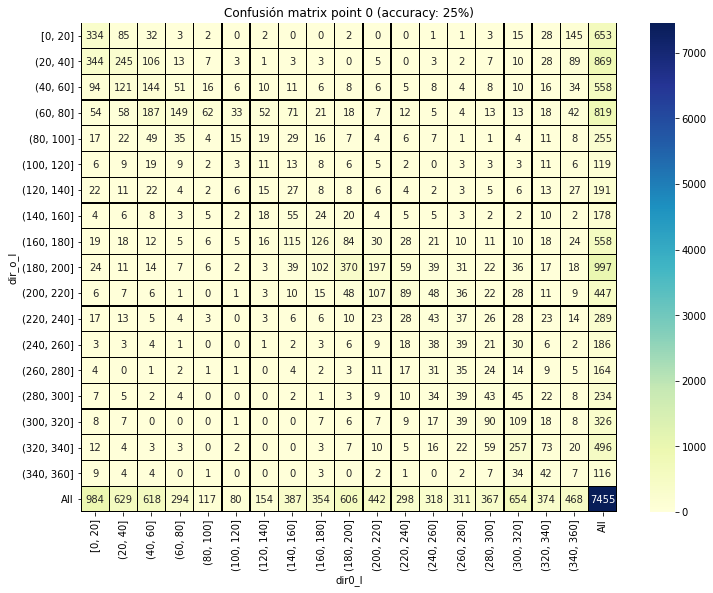

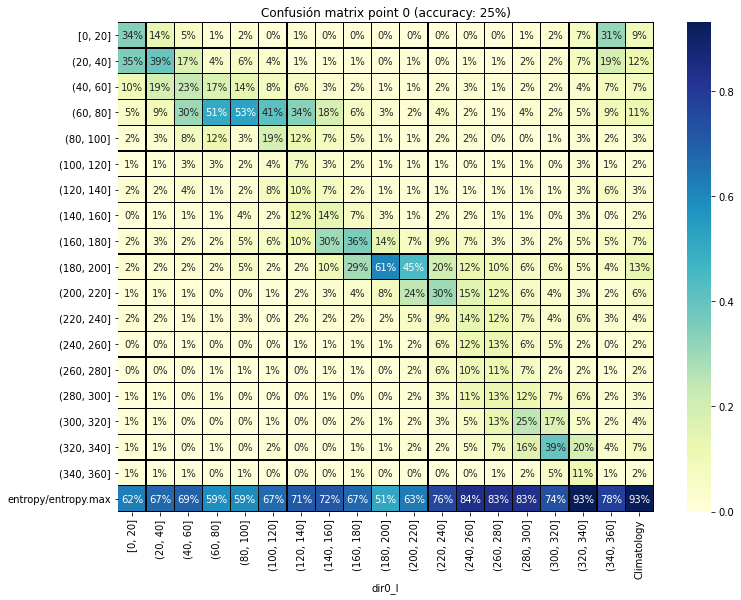

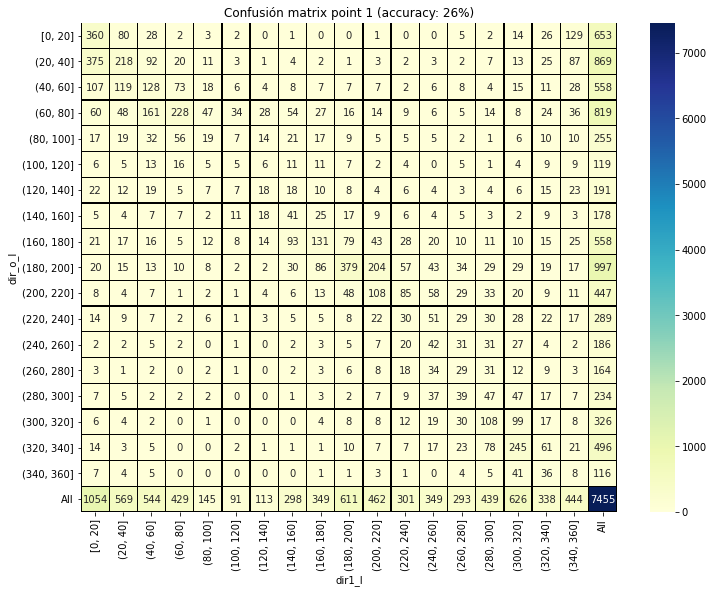

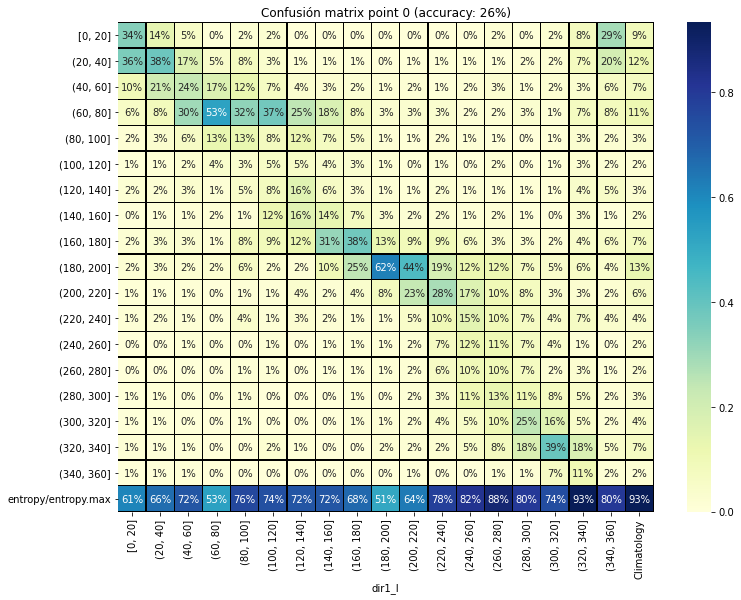

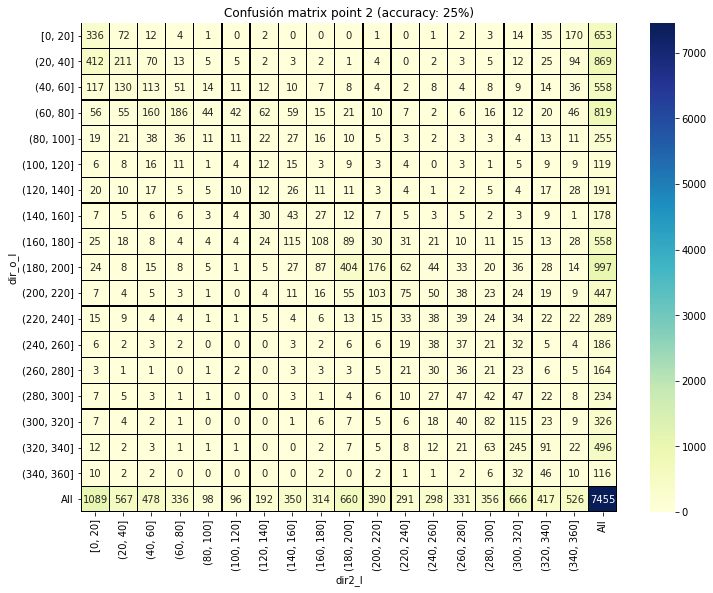

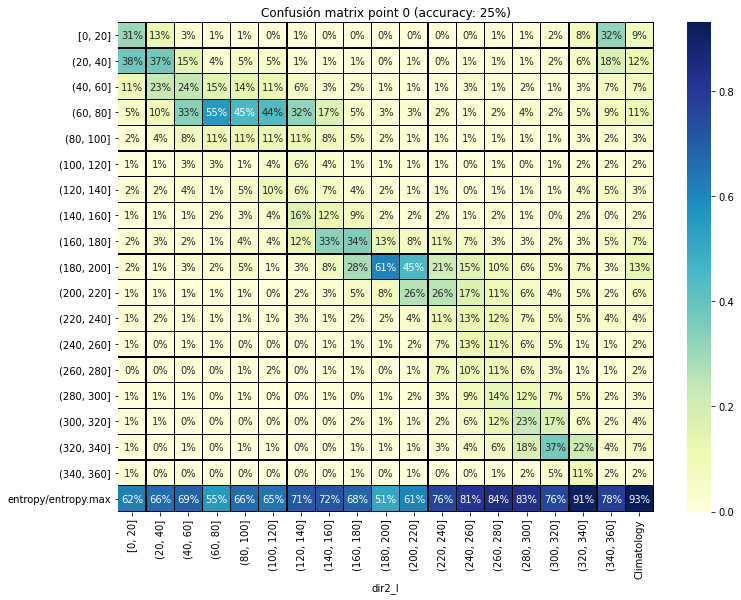

In [7]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import math
from scipy.stats import entropy
import seaborn as sns

#label dir 0,1 and 2
df_all["dir0_l"] = pd.cut(df_all["dir0"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
df_all["dir1_l"] = pd.cut(df_all["dir1"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')
df_all["dir2_l"] = pd.cut(df_all["dir2"], bins=interval,retbins=False,labels=labels).map({a:b for a,b in zip(interval,labels)}).astype('category')

acc0 = accuracy_score(df_all.dir_o_l, df_all.dir0_l)
acc1 = accuracy_score(df_all.dir_o_l, df_all.dir1_l)
acc2 = accuracy_score(df_all.dir_o_l, df_all.dir2_l)

#point 0
plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 0 (accuracy: {:.0%})".format(acc0))
global_sc = pd.crosstab(df_all.dir_o_l, df_all.dir0_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 0 (accuracy: {:.0%})".format(acc0))
column_sc = pd.crosstab(df_all.dir_o_l, df_all.dir0_l, margins=True,normalize="columns")
column_sc = column_sc.append(pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T).rename(columns={"All":"Climatology"})
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

#point1
plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 1 (accuracy: {:.0%})".format(acc1))
global_sc = pd.crosstab(df_all.dir_o_l, df_all.dir1_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 0 (accuracy: {:.0%})".format(acc1))
column_sc = pd.crosstab(df_all.dir_o_l, df_all.dir1_l, margins=True,normalize="columns")
column_sc = column_sc.append(pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T).rename(columns={"All":"Climatology"})
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');


#point2
plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 2 (accuracy: {:.0%})".format(acc2))
global_sc = pd.crosstab(df_all.dir_o_l, df_all.dir2_l,margins=True,)
sns.heatmap(global_sc,annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');

plt.figure(figsize=(12, 9))
plt.title("Confusión matrix point 0 (accuracy: {:.0%})".format(acc2))
column_sc = pd.crosstab(df_all.dir_o_l, df_all.dir2_l, margins=True,normalize="columns")
column_sc = column_sc.append(pd.DataFrame(entropy(column_sc,base=2)/(math.log2(column_sc.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc.columns).T).rename(columns={"All":"Climatology"})
sns.heatmap(column_sc,annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

#delete met model label columns
df_all = df_all.drop(["dir0_l","dir1_l","dir2_l"],axis=1)

**Add time variables. Train machine learning and results**

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from lightgbm.sklearn import LGBMClassifier
from sklearn.model_selection import train_test_split

df_all["hour"] = df_all.index.hour
df_all["month"] = df_all.index.month
df_all["dayofyear"] = df_all.index.dayofyear
df_all["weekofyear"] = df_all.index.isocalendar().week.astype(int)

#numpy randomseed
np.random.seed(1)

# target variable
Y = df_all.dir_o_l
X = df_all[["wind_gust0","mod0","dir0","wind_gust1","mod1","dir1","wind_gust2",
            "mod2","dir2","hour","month","dayofyear","weekofyear"]]

acc_t = []
for t in range (0,20):
  X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.1, )
  ml_model = LGBMClassifier(n_estimators=200).fit(X_train,y_train)
  #ml_model = ExtraTreesClassifier(n_estimators=200).fit(X_train,y_train)
  y_pred = ml_model.predict(X_test)
  acc_t.append(round(accuracy_score(y_test,y_pred),2))
  print("machine learning number:",t)
  
 
print("Accuracy Machine learning models")
df_r=pd.DataFrame({"acc_t":acc_t,});
df_r.describe()



machine learning number: 0
machine learning number: 1
machine learning number: 2
machine learning number: 3
machine learning number: 4
machine learning number: 5
machine learning number: 6
machine learning number: 7
machine learning number: 8
machine learning number: 9
machine learning number: 10
machine learning number: 11
machine learning number: 12
machine learning number: 13
machine learning number: 14
machine learning number: 15
machine learning number: 16
machine learning number: 17
machine learning number: 18
machine learning number: 19
Accuracy Machine learning models


,acc_t
count,20.000000
mean,0.430000
std,0.012566
min,0.400000
25%,0.420000
50%,0.430000
75%,0.440000
max,0.450000


**Show machine learning results**

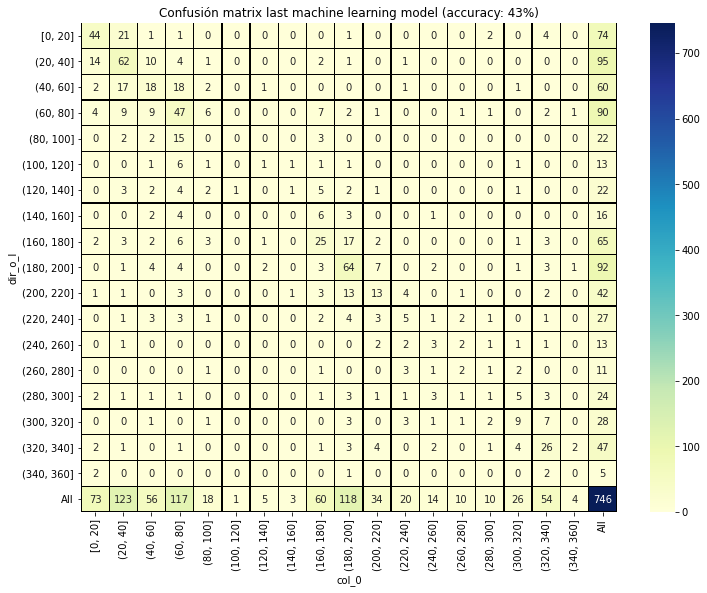

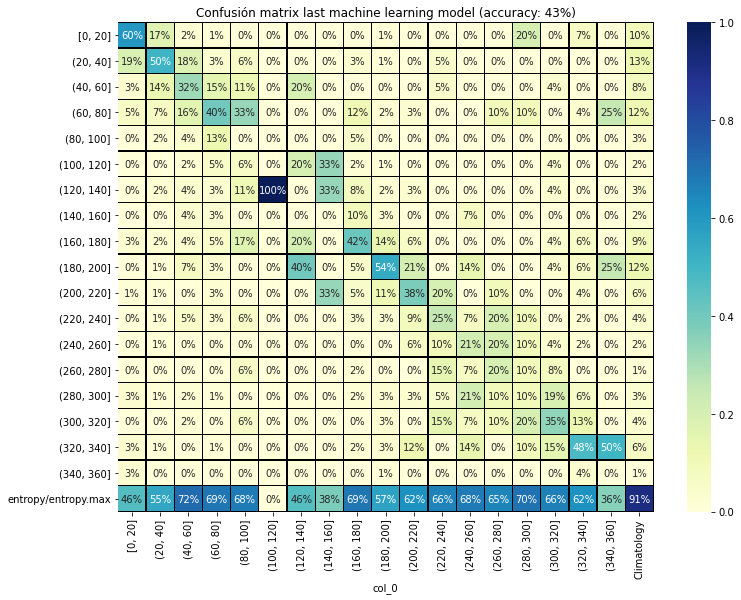

In [9]:
plt.figure(figsize=(12, 9))
plt.title("Confusión matrix last machine learning model (accuracy: {:.0%})".format(acc_t[-1]))
global_sc_ml = pd.crosstab(y_test, y_pred, margins=True,)
sns.heatmap(global_sc_ml[global_sc.columns],annot=True,cmap="YlGnBu",fmt='.0f',linewidths=.3, linecolor='black');


plt.figure(figsize=(12, 9))
plt.title("Confusión matrix last machine learning model (accuracy: {:.0%})".format(acc_t[-1]))
column_sc_ml = pd.crosstab(y_test, y_pred, margins=True,normalize="columns")
column_sc_ml = column_sc_ml.append(pd.DataFrame(entropy(column_sc_ml,base=2)/(math.log2(column_sc_ml.shape[0])),columns=["entropy/entropy.max"],
                    index=column_sc_ml.columns).T).rename(columns={"All":"Climatology"})
sns.heatmap(column_sc_ml[column_sc.columns],annot=True,cmap="YlGnBu",fmt='.0%',linewidths=.3, linecolor='black');

**Save algorithm**

In [10]:
import pickle
from sklearn.pipeline import Pipeline


estimators = [('ml_model', ml_model)]
pipe = Pipeline(estimators)
print(pipe)
al_file={"x_var":X.columns,"coor":coor,"pipe":pipe}
pickle.dump(al_file, open("/content/drive/MyDrive/Colab Notebooks/Marin/algorithms/dir_udra_d1.al", 'wb'))

Pipeline(steps=[('ml_model', LGBMClassifier(n_estimators=200))])
